# Intro 

This file does some mild explaration of the MIMIC-III dataset ***AFTER*** we have done feature selection.

## Imports
Please specify the correct path to the MIMIC-III repository in the cell below.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

MIMIC3_dir = "C:/Users/Jonas/Dropbox/DTU/Semester6/Specialkurser/Neural Networks and Logic/code/mimic3-benchmarks-1.0.0-alpha"
sys.path.append(MIMIC3_dir)

from mimic3benchmark.readers import InHospitalMortalityReader
from mimic3models.in_hospital_mortality import utils
from mimic3models import common_utils

## Loading the data

In [2]:
def read_and_extract_features(reader):
    ret = common_utils.read_chunk(reader, reader.get_number_of_examples())
    period, features = 'all', 'all'

    X = common_utils.extract_features_from_rawdata(ret['X'], ret['header'], period, features)
    return X, ret

In [3]:
reader = InHospitalMortalityReader(dataset_dir=os.path.join("data/in-hospital-mortality/train"), period_length=48.0)
(X_features, raw) = read_and_extract_features(reader)

In [4]:
headers = np.array(raw['header'][1:])
y = np.array([raw['y']])

### Reshape the data

The data is reshaped into a MultiIndex DataFrame.
This means we can index over headers, sequences and statistics, and thus the data will be easier to work with.

In [85]:
# Create the column headers for the featurs.
sample_stats = ['min', 'max', 'mean', 'std', 'skew', 'len']
subsequences = ['all', 'first10', 'first25', 'first50', 'last10', 'last25', 'last50']
tuples = [(header, subsequence, stat) for header in headers for subsequence in subsequences for stat in sample_stats]

# Append the y-values
tuples.append(('y', '', ''))
data = np.concatenate((X_features, y.T), axis=1)

# create index and dataframe
index = pd.MultiIndex.from_tuples(tuples, names=["header", "sequence", "stat"])
df = pd.DataFrame(data, columns=index)

Inspect the DataFrame

In [86]:
df

header   Capillary refill rate                                             \
sequence                   all                       first10                
stat                       min max mean std skew len     min max mean std   
0                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
1                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
2                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
3                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
4                          NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
...                        ...  ..  ...  ..  ...  ..     ...  ..  ...  ..   
17898                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17899                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17900                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17901                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   
17902                      NaN NaN  NaN NaN  NaN NaN     NaN NaN  NaN NaN   

header    ...        pH                                                      \
sequence  ...    last25                    last50                             
stat      ...       std          skew  len    min   max      mean       std   
0         ...  0.000000  0.000000e+00  1.0   5.00  5.00  5.000000  0.000000   
1         ...  0.004714 -7.071068e-01  3.0   7.37  7.38  7.376667  0.004714   
2         ...  0.000000  0.000000e+00  1.0   7.40  7.44  7.426667  0.018856   
3         ...  0.000000  0.000000e+00  1.0   7.41  7.49  7.450000  0.040000   
4         ...       NaN           NaN  NaN    NaN   NaN       NaN       NaN   
...       ...       ...           ...  ...    ...   ...       ...       ...   
17898     ...  1.164484 -7.064811e-01  3.0   5.00  7.49  6.807500  1.046240   
17899     ...  0.000000  0.000000e+00  1.0   7.50  7.50  7.500000  0.000000   
17900     ...       NaN           NaN  NaN    NaN   NaN       NaN       NaN   
17901     ...       NaN           NaN  NaN    NaN   NaN       NaN       NaN   
17902     ...  0.015000 -8.884434e-14  2.0   7.33  7.38  7.360000  0.016330   

header                     y  
sequence                      
stat          skew  len       
0         0.000000  1.0  0.0  
1        -0.707107  3.0  0.0  
2        -0.707107  3.0  0.0  
3         0.000000  2.0  0.0  
4              NaN  NaN  1.0  
...            ...  ...  ...  
17898    -1.137264  4.0  0.0  
17899     0.000000  1.0  0.0  
17900          NaN  NaN  0.0  
17901          NaN  NaN  0.0  
17902    -0.688919  6.0  0.0  

[17903 rows x 715 columns]

To index this DataFrame, we need a pandas.IndexSlice

In [87]:
idx = pd.IndexSlice

# Data Exploration

First, we check the amount of data and the data types:

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17903 entries, 0 to 17902
Columns: 715 entries, ('Capillary refill rate', 'all', 'min') to ('y', '', '')
dtypes: float64(715)
memory usage: 97.7 MB


Because all values are floats, we can dig straight in.

### Data split
Check the number of mortalities

In [89]:
gt0 = np.sum(df.loc[:, idx['y']].gt(0))
eq0 = df.shape[0] - gt0

print(f"Mortalities: {gt0}. Survivors: {eq0}. Mortality rate: {round(gt0/eq0 * 100, 3)}%.")

Mortalities: 2423. Survivors: 15480. Mortality rate: 15.652%.


### Missing Data
Check the number of values for each variable

In [90]:
data = df.loc[:, idx[:, ('all', ''), ('mean', '')]].droplevel(['sequence', 'stat'], axis=1)
data.count()

header
Capillary refill rate                   323
Diastolic blood pressure              17689
Fraction inspired oxygen               5309
Glascow coma scale eye opening        17739
Glascow coma scale motor response     17737
Glascow coma scale total              10387
Glascow coma scale verbal response    17736
Glucose                               17886
Heart Rate                            17689
Height                                 3385
Mean blood pressure                   17687
Oxygen saturation                     17783
Respiratory rate                      17683
Systolic blood pressure               17689
Temperature                           17554
Weight                                13052
pH                                    14776
y                                     17903
dtype: int64

We clearly see, that especially the Capillary refill rate has an extreme number of missing values!

Let's drop it!

In [91]:
df = df.drop(columns=['Capillary refill rate'])

## Pairwise Relationships (correlations)

In the following, we will restict ourselves to the *mean* values over the *entire 48 hours of initial stay* in the ICU.

In [92]:
data = df.loc[:, idx[:, ('all', ''), ('mean', '')]].droplevel(['sequence', 'stat'], axis=1)

Then, we check the correlations among variables:

In [93]:
corr = data.corr()
corr

header,Diastolic blood pressure,Fraction inspired oxygen,Glascow coma scale eye opening,Glascow coma scale motor response,Glascow coma scale total,Glascow coma scale verbal response,Glucose,Heart Rate,Height,Mean blood pressure,Oxygen saturation,Respiratory rate,Systolic blood pressure,Temperature,Weight,pH,y
header,,,,,,,,,,,,,,,,,
Diastolic blood pressure,1.000000,-0.031745,-0.020401,-0.000603,-0.060781,-0.011734,-0.001408,0.078958,0.001504,0.142882,0.003360,0.003117,0.170881,0.006164,-0.001301,-0.001516,-0.012010
Fraction inspired oxygen,-0.031745,1.000000,0.078678,-0.000773,0.052592,0.224055,-0.007213,0.067589,0.029072,-0.028681,0.038571,-0.004232,-0.147618,0.007345,-0.009217,-0.015512,0.078559
Glascow coma scale eye opening,-0.020401,0.078678,1.000000,0.825326,0.933595,0.770459,-0.012564,-0.057284,-0.047781,-0.037568,0.004642,0.003451,-0.023919,-0.047279,-0.004723,-0.043331,-0.314576
Glascow coma scale motor response,-0.000603,-0.000773,0.825326,1.000000,0.875041,0.655755,-0.008084,-0.079434,-0.041219,-0.011675,0.004254,-0.003395,0.038037,-0.030089,0.000905,-0.037761,-0.318425
Glascow coma scale total,-0.060781,0.052592,0.933595,0.875041,1.000000,0.924772,-0.067828,-0.117992,-0.443803,-0.057942,-0.098377,0.093064,0.002266,-0.259680,-0.050854,-0.023537,-0.327745
Glascow coma scale verbal response,-0.011734,0.224055,0.770459,0.655755,0.924772,1.000000,-0.015014,-0.060339,-0.040436,-0.038554,0.005313,-0.006908,-0.022944,-0.059884,-0.006597,-0.052816,-0.250962
Glucose,-0.001408,-0.007213,-0.012564,-0.008084,-0.067828,-0.015014,1.000000,-0.003932,0.003775,0.003773,-0.000535,-0.000639,0.015302,-0.000710,-0.000248,0.000382,0.004718
Heart Rate,0.078958,0.067589,-0.057284,-0.079434,-0.117992,-0.060339,-0.003932,1.000000,-0.027224,0.056890,-0.006959,-0.000233,-0.125440,0.052613,0.001207,-0.006837,0.089596
Height,0.001504,0.029072,-0.047781,-0.041219,-0.443803,-0.040436,0.003775,-0.027224,1.000000,0.003142,-0.019204,-0.000646,-0.001852,-0.008114,0.285581,0.004810,-0.026364


Now, this table is **HUGE**.

Let's restrict ourselves and look at the 5 variables that has the highes correlation with our y-variable.

In [94]:
corr_idx =corr.loc[:, 'y'].abs().nlargest(6).keys()
corr.loc[corr_idx, corr_idx]

header,y,Glascow coma scale total,Glascow coma scale motor response,Glascow coma scale eye opening,Glascow coma scale verbal response,Heart Rate
header,,,,,,
y,1.000000,-0.327745,-0.318425,-0.314576,-0.250962,0.089596
Glascow coma scale total,-0.327745,1.000000,0.875041,0.933595,0.924772,-0.117992
Glascow coma scale motor response,-0.318425,0.875041,1.000000,0.825326,0.655755,-0.079434
Glascow coma scale eye opening,-0.314576,0.933595,0.825326,1.000000,0.770459,-0.057284
Glascow coma scale verbal response,-0.250962,0.924772,0.655755,0.770459,1.000000,-0.060339
Heart Rate,0.089596,-0.117992,-0.079434,-0.057284,-0.060339,1.000000


Clearly, the GCS variable is interesting. 

BUT, let's only look at the glasgow coma scale total, and ignore the others.

So, drop the others and repeat computation.

In [95]:
corr_new = data.drop(corr.columns[[2, 3, 5]], axis=1).corr()
corr_new_idx = corr_new.loc[:, 'y'].abs().nlargest(6).keys()
corr_new.loc[corr_new_idx, corr_new_idx]

header,y,Glascow coma scale total,Heart Rate,Systolic blood pressure,Fraction inspired oxygen,Mean blood pressure
header,,,,,,
y,1.000000,-0.327745,0.089596,-0.080551,0.078559,-0.037747
Glascow coma scale total,-0.327745,1.000000,-0.117992,0.002266,0.052592,-0.057942
Heart Rate,0.089596,-0.117992,1.000000,-0.125440,0.067589,0.056890
Systolic blood pressure,-0.080551,0.002266,-0.125440,1.000000,-0.147618,0.360329
Fraction inspired oxygen,0.078559,0.052592,0.067589,-0.147618,1.000000,-0.028681
Mean blood pressure,-0.037747,-0.057942,0.056890,0.360329,-0.028681,1.000000


### Let's plot it! 

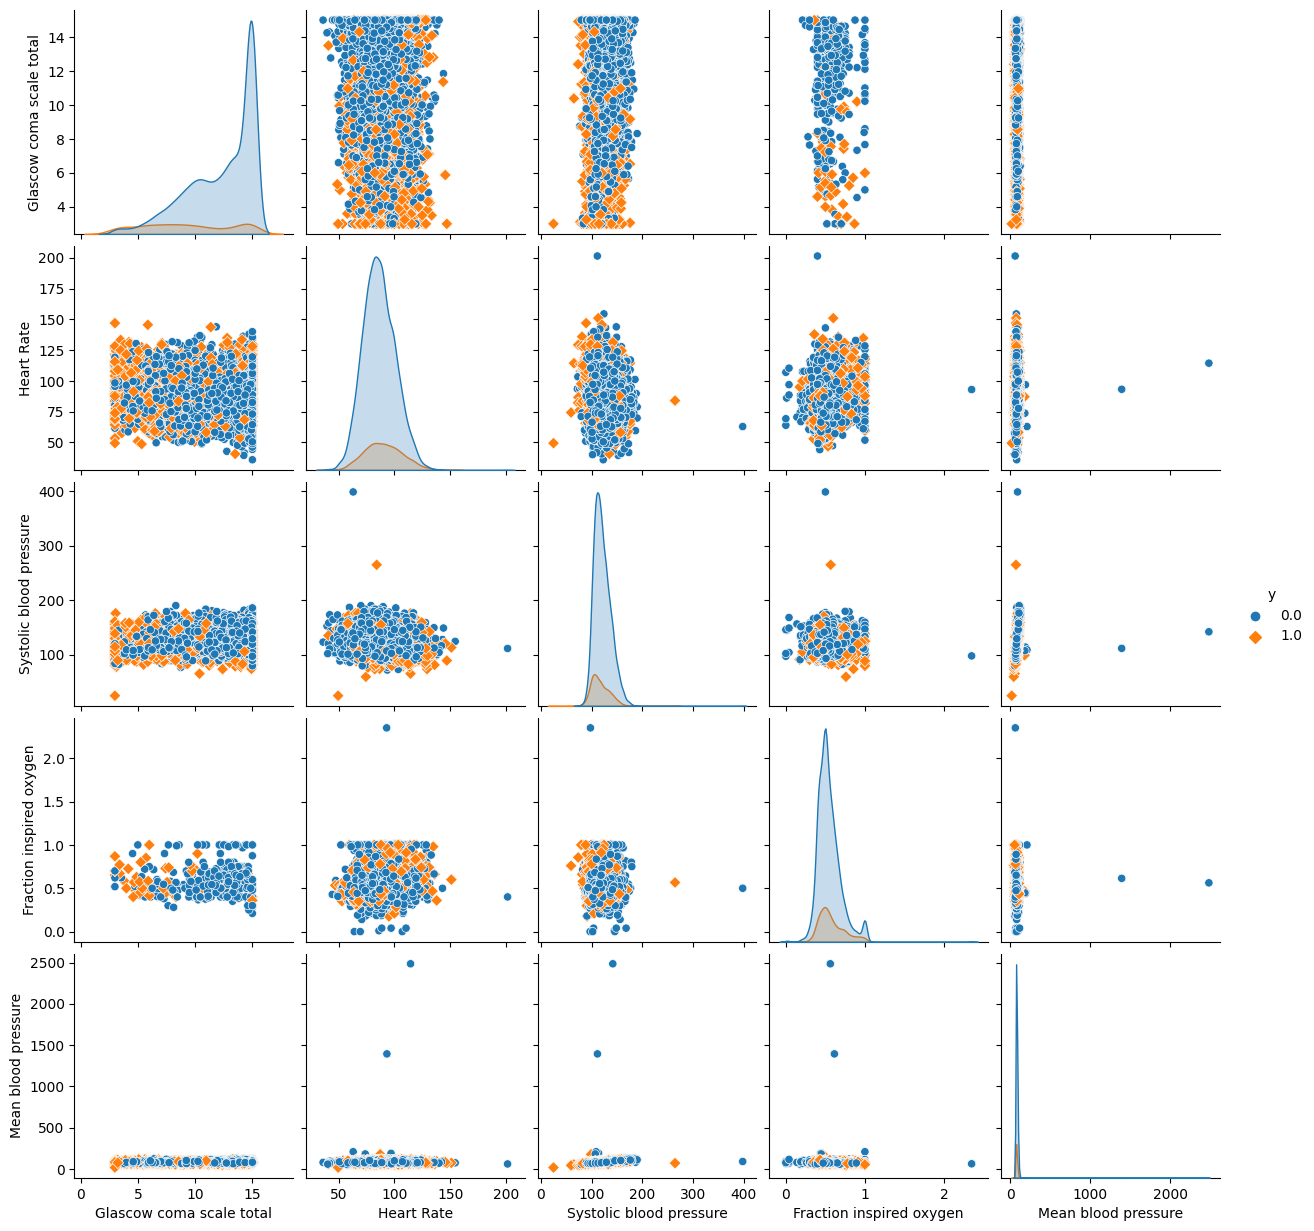

In [96]:
sns.pairplot(data, vars=corr_new_idx[1:], hue='y', markers=["o", "D"])

Let's have a closer look at some selected variables:

## Glascow Coma Scale 

Let's check which statistics leads to highest correlation:

In [97]:
data = df.loc[:, idx[('Glascow coma scale total', 'y'), ('all', ''), :]].droplevel(['header', 'sequence'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

stat,min,max,mean,std,skew,len,y
stat,,,,,,,
min,1.000000,0.449967,0.756073,-0.802390,0.017238,-0.113455,-0.156766
max,0.449967,1.000000,0.829647,0.110193,-0.197860,-0.149057,-0.346919
mean,0.756073,0.829647,1.000000,-0.338238,-0.357842,-0.156807,-0.327745
std,-0.802390,0.110193,-0.338238,1.000000,-0.079836,-0.021638,-0.037443
skew,0.017238,-0.197860,-0.357842,-0.079836,1.000000,-0.043522,0.147594
len,-0.113455,-0.149057,-0.156807,-0.021638,-0.043522,1.000000,0.058161
y,-0.156766,-0.346919,-0.327745,-0.037443,0.147594,0.058161,1.000000


We see, that both **max** and **mean** might be interesting!

Likewise, we can check the different periods:

In [98]:
data = df.loc[:, idx[('Glascow coma scale total', 'y'), :, ('max', '')]].droplevel(['header', 'stat'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

sequence,all,first10,first25,first50,last10,last25,last50,y
sequence,,,,,,,,
all,1.000000,0.591373,0.734834,0.874518,0.825354,0.852712,0.887973,-0.346919
first10,0.591373,1.000000,0.850533,0.706973,0.442203,0.457280,0.477609,-0.131015
first25,0.734834,0.850533,1.000000,0.854904,0.571018,0.589486,0.612504,-0.205898
first50,0.874518,0.706973,0.854904,1.000000,0.699802,0.718670,0.748323,-0.282026
last10,0.825354,0.442203,0.571018,0.699802,1.000000,0.969200,0.932298,-0.414897
last25,0.852712,0.457280,0.589486,0.718670,0.969200,1.000000,0.964147,-0.411348
last50,0.887973,0.477609,0.612504,0.748323,0.932298,0.964147,1.000000,-0.398707
y,-0.346919,-0.131015,-0.205898,-0.282026,-0.414897,-0.411348,-0.398707,1.000000


From this table, it seems we have many potentially interesting periods.

Let's plot some histograms!

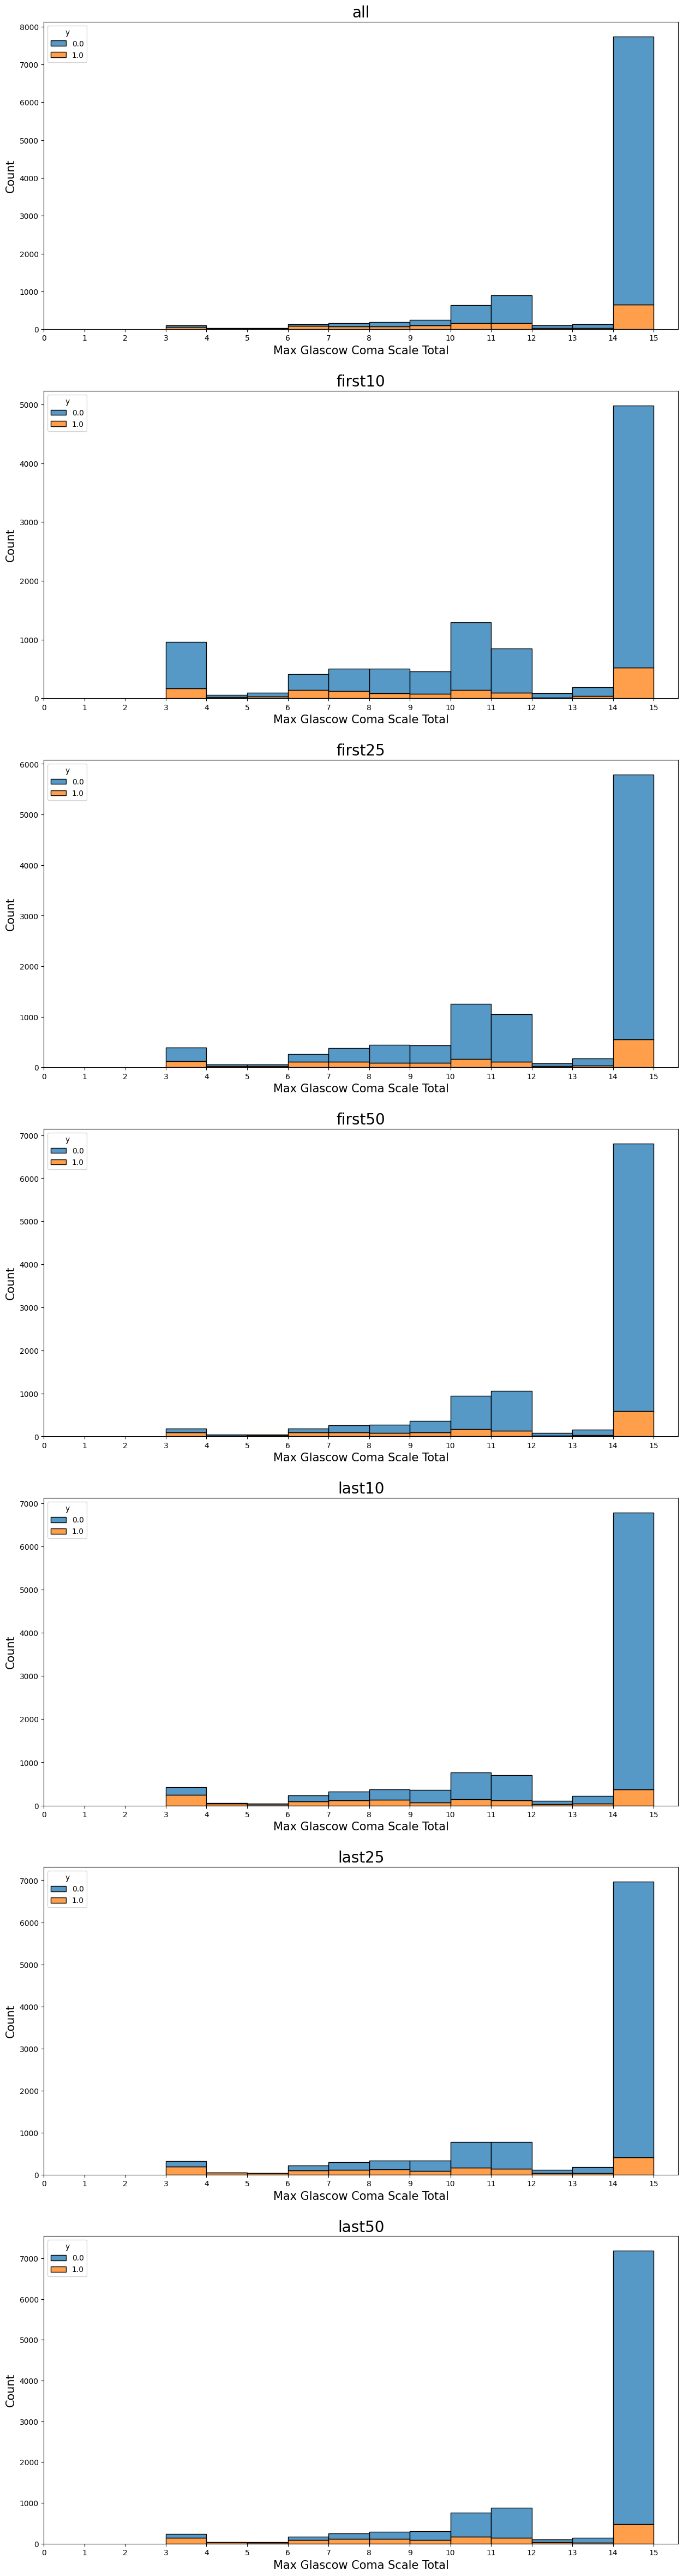

In [99]:
fig, axs = plt.subplots(nrows=7, figsize=(15,60))
fig.subplots_adjust(hspace=0.2)

for (i, seq) in enumerate(subsequences):
    g = sns.histplot(data=data, x=seq, bins=np.arange(3, 16), hue='y', multiple="stack", ax=axs[i])
    g.set_xticks(range(16))
    g.axes.set_title(f"{seq}",fontsize=20)
    g.set_xlabel("Max Glascow Coma Scale Total",fontsize=15)
    g.set_ylabel("Count",fontsize=15)

### Generate Constraint
Having found some correlation, we will try to look for a more concrete constraint value.

First, we find the number of mortalities among patients with a GCST below 8 for each interval sequence, and for both **max** and **mean**:

In [119]:
threshold = 3

data = df.loc[:, idx[('Glascow coma scale total', 'y'), :, ('max', 'mean', '')]].dropna()
mortality = data.index[data.loc[:, 'y'].eq(1)]

df1 = data[data.loc[mortality] <= threshold].count()
df1 = df1.reset_index().rename(columns={0: 'mortalities'})

df2 = data[data.loc[mortality] <= threshold].count() / data[data <= threshold].count()
df2 = df2.reset_index(drop=True).rename('rate')

pd.concat([df1, df2], axis=1)

,header,sequence,stat,mortalities,rate
0,Glascow coma scale total,all,max,62,0.607843
1,Glascow coma scale total,first10,max,173,0.179834
2,Glascow coma scale total,first25,max,125,0.314861
3,Glascow coma scale total,first50,max,90,0.494505
4,Glascow coma scale total,last10,max,244,0.582339
5,Glascow coma scale total,last25,max,194,0.611987
6,Glascow coma scale total,last50,max,142,0.612069
7,Glascow coma scale total,all,mean,62,0.607843
8,Glascow coma scale total,first10,mean,173,0.179834
9,Glascow coma scale total,first25,mean,125,0.314861


From this, we can extract the following appx. constraint:
    
  **If mean GCST in the last 10 % is less than or equal to 8, probability of mortality is above 40 %**

We can find the parameters to encode the constraint:

In [117]:
df.columns.get_loc(idx['Glascow coma scale total', 'last10', 'max']) + 42

235

In [121]:
column = df.loc[:, idx['Glascow coma scale total', 'last10', 'max']]
(8 - column.mean()) / column.std()

-1.3814612599794032

## Systolic blood pressure
We follow the same approach for the Systolic blood pressure, as we did for the glasgow coma scale.

In [101]:
data = df.loc[:, idx[('Systolic blood pressure', 'y'), ('all', ''), :]].droplevel(['header', 'sequence'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

stat,min,max,mean,std,skew,len,y
stat,,,,,,,
min,1.000000,0.040365,0.570698,-0.089530,0.302701,-0.093222,-0.122702
max,0.040365,1.000000,0.269182,0.976421,0.142264,0.011556,0.007780
mean,0.570698,0.269182,1.000000,0.241226,-0.187044,-0.030748,-0.080551
std,-0.089530,0.976421,0.241226,1.000000,0.092468,0.018341,0.028120
skew,0.302701,0.142264,-0.187044,0.092468,1.000000,0.013304,-0.000259
len,-0.093222,0.011556,-0.030748,0.018341,0.013304,1.000000,0.027667
y,-0.122702,0.007780,-0.080551,0.028120,-0.000259,0.027667,1.000000


It seems, that **min** and **mean** could be interesting.

Let's look at the periods:

In [102]:
data = df.loc[:, idx[('Systolic blood pressure', 'y'), :, ('min', '')]].droplevel(['header', 'stat'], axis=1)
data.rename(columns = {'':'y'}, inplace=True)

data.corr()

sequence,all,first10,first25,first50,last10,last25,last50,y
sequence,,,,,,,,
all,1.000000,0.615428,0.726494,0.840059,0.501546,0.596074,0.722871,-0.122702
first10,0.615428,1.000000,0.862678,0.750103,0.361233,0.361208,0.363772,-0.063180
first25,0.726494,0.862678,1.000000,0.879854,0.372302,0.385127,0.396260,-0.073983
first50,0.840059,0.750103,0.879854,1.000000,0.395763,0.413495,0.435869,-0.088360
last10,0.501546,0.361233,0.372302,0.395763,1.000000,0.855120,0.715551,-0.126753
last25,0.596074,0.361208,0.385127,0.413495,0.855120,1.000000,0.842286,-0.134273
last50,0.722871,0.363772,0.396260,0.435869,0.715551,0.842286,1.000000,-0.131634
y,-0.122702,-0.063180,-0.073983,-0.088360,-0.126753,-0.134273,-0.131634,1.000000


It could look like many sequences are interesting.

Let's make some plots!

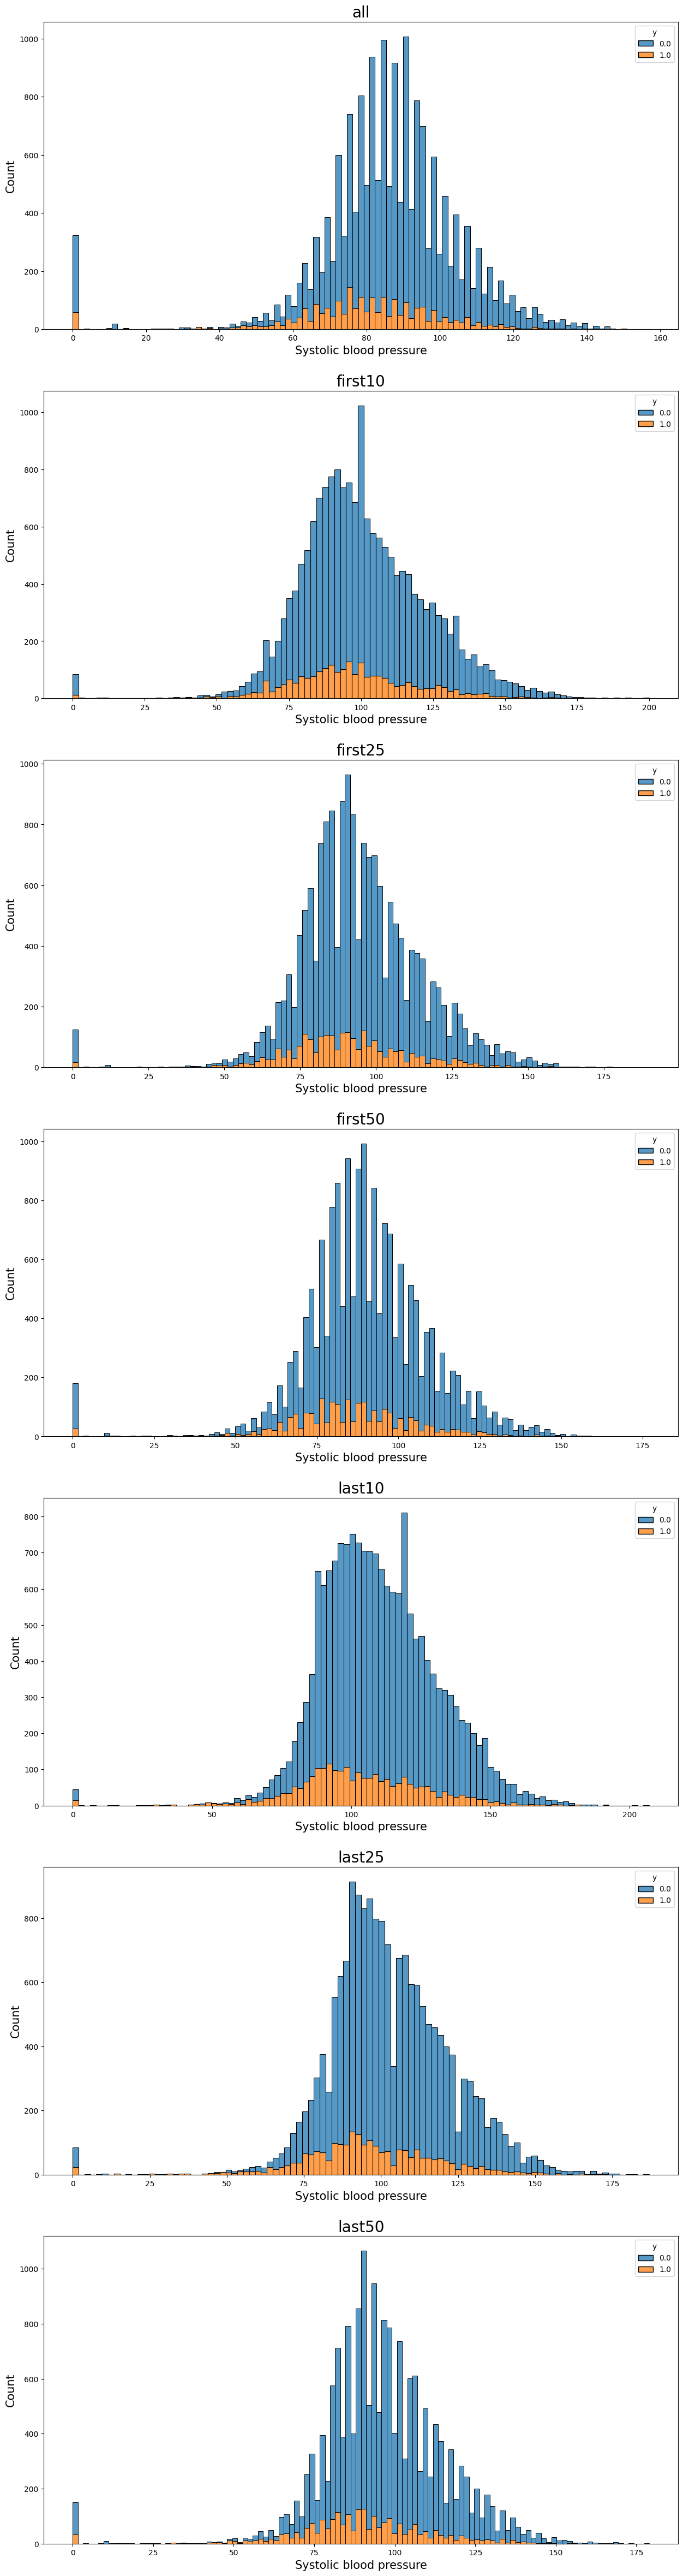

In [103]:
fig, axs = plt.subplots(nrows=7, figsize=(15,60))
fig.subplots_adjust(hspace=0.2)

for (i, seq) in enumerate(subsequences):
    g = sns.histplot(data=data, x=seq, hue='y', multiple="stack", ax=axs[i])
    g.axes.set_title(f"{seq}",fontsize=20)
    g.set_xlabel("Systolic blood pressure",fontsize=15)
    g.set_ylabel("Count",fontsize=15)

### Generate Constraint
Having found some correlation, we will again try to look for a more concrete constraint value.

In [104]:
threshold = 80

data = df.loc[:, idx[('Systolic blood pressure', 'y'), :, ('min', 'mean', '')]].dropna()
mortality = data.index[data.loc[:, 'y'].eq(1)]

df1 = data[data.loc[mortality] <= threshold].count()
df1 = df1.reset_index().rename(columns={0: 'mortalities'})

df2 = data[data.loc[mortality] <= threshold].count() / data[data <= threshold].count()
df2 = df2.reset_index(drop=True).rename('rate')

pd.concat([df1, df2], axis=1)

,header,sequence,stat,mortalities,rate
0,Systolic blood pressure,all,min,1148,0.208424
1,Systolic blood pressure,first10,min,450,0.197368
2,Systolic blood pressure,first25,min,663,0.199279
3,Systolic blood pressure,first50,min,862,0.199399
4,Systolic blood pressure,last10,min,278,0.377205
5,Systolic blood pressure,last25,min,453,0.332599
6,Systolic blood pressure,last50,min,644,0.272650
7,Systolic blood pressure,all,mean,12,0.666667
8,Systolic blood pressure,first10,mean,27,0.402985
9,Systolic blood pressure,first25,mean,15,0.416667


From this, we can extract the following appx. constraint:
    
  **If min SBP in the last 50 % is less than 80, probability of mortality is above 25 %**

In [122]:
df.columns.get_loc(idx['Systolic blood pressure', 'last50', 'min']) + 42

582

In [123]:
column = df.loc[:, idx['Systolic blood pressure', 'last50', 'min']]
(8 - column.mean()) / column.std()

-4.513665214583726